In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import requests
import seaborn as sns
import itertools
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

In [2]:
#url='https://www.kaggle.com/kemical/kickstarter-projects/downloads/ks-projects-201801.csv'
#df=pd.read_csv(url, header=None)

In [3]:
df = pd.read_csv('ks-projects-201801.csv',error_bad_lines=False)

b'Skipping line 20454: expected 15 fields, saw 19\nSkipping line 27266: expected 15 fields, saw 23\nSkipping line 47738: expected 15 fields, saw 19\nSkipping line 54556: expected 15 fields, saw 23\n'
b'Skipping line 75000: expected 15 fields, saw 17\nSkipping line 95465: expected 15 fields, saw 21\nSkipping line 102283: expected 15 fields, saw 26\nSkipping line 129576: expected 15 fields, saw 26\n'
b'Skipping line 170525: expected 15 fields, saw 16\nSkipping line 177348: expected 15 fields, saw 26\n'
b'Skipping line 204638: expected 15 fields, saw 19\nSkipping line 211470: expected 15 fields, saw 26\nSkipping line 218306: expected 15 fields, saw 16\nSkipping line 252430: expected 15 fields, saw 17\nSkipping line 259262: expected 15 fields, saw 26\n'
b'Skipping line 266098: expected 15 fields, saw 18\nSkipping line 300233: expected 15 fields, saw 17\nSkipping line 307065: expected 15 fields, saw 27\nSkipping line 313893: expected 15 fields, saw 19\n'
b'Skipping line 348033: expected 15 

https://www.kaggle.com/kromel/kickstarter-successful-vs-failed/data

In [4]:
df=df.sample(1000, random_state=32)

In [5]:
df.shape

(1000, 15)

In [6]:
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
711859,292924641,"NextGen, Use any platform on any devive, rules...",Software,Technology,SEK,2014-11-04,50000,2014-10-21 15:14:46,0,failed,0,SE,0,0.00,6726.22
443026,1865145137,Cassidy Jones Adventures: Paperback Books For ...,Fiction,Publishing,USD,2012-07-12,1000,2012-06-28 01:35:01,1505,successful,43,US,1505,1505.00,1000.00
305960,1549399998,· Guenda · products for connecting with nature...,Embroidery,Crafts,MXN,2017-12-25,60000.00,2017-11-25 15:56:14,60520.00,successful,84,MX,112.64,3067.57,3041.21
56190,1111918633,The ABCs of Nightmares,Children's Books,Publishing,CAD,2016-11-24,8500.00,2016-10-24 01:05:08,2764.00,failed,49,CA,0,2048.77,6300.50
867977,7.40164e+08,The Toughest,Documentary,Film & Video,USD,2016-04-02,2295.00,2016-03-03 15:46:40,0.00,failed,0,US,0,0.00,2295.00


In [7]:
df.dtypes

ID                   object
name                 object
category             object
main_category        object
currency             object
deadline             object
goal                 object
launched             object
pledged              object
state                object
backers              object
country              object
usd pledged          object
usd_pledged_real    float64
usd_goal_real       float64
dtype: object

# Data Cleaning

### Nulls

In [8]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
df_missingData = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
display(df_missingData.head(20))
df.isnull().sum().max()

,Total,Percent
usd pledged,8,0.008
usd_goal_real,0,0.000
usd_pledged_real,0,0.000
country,0,0.000
backers,0,0.000
state,0,0.000
pledged,0,0.000
launched,0,0.000
goal,0,0.000
deadline,0,0.000


8

In [9]:
dfNoNulls = df.copy()
dfNoNulls.dropna(inplace=True)
print ("Before Dropping Nulls: ", df.shape[0])
print ("After Dropping Nulls: ", dfNoNulls.shape[0])
print ("Rows Removed: ", df.shape[0] - dfNoNulls.shape[0])
print ("Percent Removed: {:.0%}".format(1-(dfNoNulls.shape[0])/df.shape[0]))   

Before Dropping Nulls:  1000
After Dropping Nulls:  992
Rows Removed:  8
Percent Removed: 1%


### "usd pledged" Column: Bad Formatting

In [10]:
dfDropPldg = dfNoNulls.copy()
for row in dfDropPldg.iterrows():
    if str(row[1]['usd pledged']).count('.') > 1:
        print (row)
        dfDrop = dfDropPldg.drop(row[0])
        break;
# Use a comprehension for this

In [11]:
dfDropCntry = dfDropPldg.copy()
dfDropCntry = dfDropCntry.drop(dfDropCntry[(dfDropCntry['country'] != 'US')].index)

In [12]:
dfDropCat = dfDropCntry.copy()
dfDropCat = dfDropCat.drop('category',axis=1)

In [13]:
dfDropState = dfDropCat.copy()
dropVals = ['live','suspended','canceled','fnceled']
for dv in dropVals:
    dfDropState = dfDropState.drop(dfDropState[(dfDropState['state'] == dv)].index)

### Convert to Numeric

In [14]:
dfNum = dfDropState.copy()
numCols = ['goal','pledged','backers','usd pledged']
for c in numCols:
    dfNum[c] = dfNum[c].apply(pd.to_numeric)

In [15]:
dfNum.describe()

,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,7.000000e+02,700.000000,700.000000,700.000000,700.000000,7.000000e+02
mean,2.324955e+04,8470.745529,120.361429,6414.505000,8470.745529,2.324955e+04
std,1.286013e+05,31772.481735,492.706359,27647.878257,31772.481735,1.286013e+05
min,1.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000e+00
25%,2.000000e+03,81.000000,3.000000,35.000000,81.000000,2.000000e+03
50%,5.000000e+03,1102.500000,20.000000,802.000000,1102.500000,5.000000e+03
75%,1.500000e+04,5208.500000,71.000000,4067.750000,5208.500000,1.500000e+04
max,3.000000e+06,588903.000000,9677.000000,588903.000000,588903.000000,3.000000e+06


# Encoding

In [16]:
sorted(dfNum.state.unique())

['failed', 'successful']

In [17]:
dfEnc = pd.DataFrame()
dfEnc = dfNum.copy()
dfEnc['state'] = dfNum.state.astype('category')
dfEnc['state_code'] = np.where(dfEnc['state'].str.contains('successful'),1,0)

In [18]:
dfEnc = pd.get_dummies(dfEnc, columns=['main_category'], prefix = ['cat'])

In [19]:
dfEnc.shape

(700, 29)

In [20]:
dfEnc.reset_index(inplace=True, drop=True)

# Set Data and Target

In [21]:
contCols = ['goal','pledged','backers','usd pledged', 'usd_pledged_real', 'usd_goal_real']

In [22]:
dataCols = []
dataCols += contCols
dataCols += [col for col in dfEnc.columns if 'cat_' in col]

In [23]:
dataCols

['goal',
 'pledged',
 'backers',
 'usd pledged',
 'usd_pledged_real',
 'usd_goal_real',
 'cat_Art',
 'cat_Comics',
 'cat_Crafts',
 'cat_Dance',
 'cat_Design',
 'cat_Fashion',
 'cat_Film & Video',
 'cat_Food',
 'cat_Games',
 'cat_Journalism',
 'cat_Music',
 'cat_Photography',
 'cat_Publishing',
 'cat_Technology',
 'cat_Theater']

In [24]:
y=dfEnc['state_code']
X=dfEnc[dataCols]

In [25]:
X.head()

,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real,cat_Art,cat_Comics,cat_Crafts,cat_Dance,...,cat_Fashion,cat_Film & Video,cat_Food,cat_Games,cat_Journalism,cat_Music,cat_Photography,cat_Publishing,cat_Technology,cat_Theater
0,1000.0,1505.0,43.0,1505.0,1505.0,1000.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,2295.0,0.0,0.0,0.0,0.0,2295.0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2000.0,2001.0,21.0,2001.0,2001.0,2000.0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,2500.0,60.0,3.0,60.0,60.0,2500.0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,3000.0,360.0,12.0,360.0,360.0,3000.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


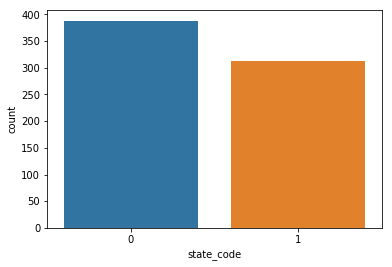

In [26]:
sns.countplot(x=y,data=dfNum)
plt.show()

In [27]:
print (y.shape)
y.unique()

(700,)


array([1, 0])

# ISSUE

The Cross Val results for LogisticRegression are returning the same values regardless of the regularization parameter "C".  RidgeClassifier returns the expected resutls.  So does Lasso LogisticRegression.


### Ridge: LogisticRegression 

SHOULD BE DIFFERENT FOR SUCH DIFFERENT C VALUES

In [28]:
rdgLr1 = LogisticRegression(C=.03, penalty='l2')
print(rdgLr1)
cross_val_score(rdgLr1, X,y, cv=10)

LogisticRegression(C=0.03, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


array([ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  0.98550725])

In [29]:
rdgLr2 = LogisticRegression(C=1000, penalty='l2')
print(rdgLr2)
cross_val_score(rdgLr2, X,y, cv=10)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


array([ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  0.98550725])

### Ridge: RidgeClassifer

In [30]:
rdgLr3 = linear_model.RidgeClassifier(alpha=.03)
print(rdgLr3)
cross_val_score(rdgLr3, X, y, cv=10)

RidgeClassifier(alpha=0.03, class_weight=None, copy_X=True,
        fit_intercept=True, max_iter=None, normalize=False,
        random_state=None, solver='auto', tol=0.001)


array([ 0.74647887,  0.81690141,  0.62857143,  0.58571429,  0.75714286,
        0.7       ,  0.62857143,  0.67142857,  0.62318841,  0.68115942])

In [31]:
rdgLr4 = linear_model.RidgeClassifier(alpha=1000)
print(rdgLr4)
cross_val_score(rdgLr3, X, y, cv=10)

RidgeClassifier(alpha=1000, class_weight=None, copy_X=True,
        fit_intercept=True, max_iter=None, normalize=False,
        random_state=None, solver='auto', tol=0.001)


array([ 0.74647887,  0.81690141,  0.62857143,  0.58571429,  0.75714286,
        0.7       ,  0.62857143,  0.67142857,  0.62318841,  0.68115942])

### Lasso: LogisticRegression

In [32]:
lssLr1 = LogisticRegression(C=.03, penalty='l1')
print(lssLr1)
cross_val_score(lssLr1, X,y, cv=10)

LogisticRegression(C=0.03, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


array([ 1.        ,  1.        ,  1.        ,  0.98571429,  0.98571429,
        1.        ,  1.        ,  0.98571429,  0.97101449,  0.98550725])

In [33]:
lssLr2 = LogisticRegression(C=100, penalty='l1')
print(lssLr2)
cross_val_score(lssLr2, X,y, cv=10)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


array([ 0.95774648,  0.97183099,  0.95714286,  0.91428571,  0.97142857,
        0.95714286,  0.95714286,  0.92857143,  0.97101449,  0.94202899])

### Vanilla Regression

In [34]:
vLr1 = LogisticRegression()
print(vLr1)
cross_val_score(vLr1, X,y, cv=10)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


array([ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  0.98550725])

# Isolate Features

# Manual Iterations

In [262]:
def loopIterations2(X,y,listOfCs):

    for c in listOfCs:

        B_rdgLr4 = LogisticRegression(C=c, penalty='l2').fit(X,y)
        score = B_rdgLr4.score(X,y)
        cvs = cross_val_score(B_rdgLr4, X,y, cv=5)
        
        print("C:{0:.6f}   Score:{1}".format(c,score))
        print ("  {}\n".format(cvs))
        

In [252]:
def manualIterations(X,y):

    B_rdgLr3 = LogisticRegression(C=300, penalty='l2').fit(X,y)
    print('300\t' + str(B_rdgLr3.score(X,y)))
    
    B_rdgLr3 = LogisticRegression(C=30, penalty='l2').fit(X,y)
    print('30\t' + str(B_rdgLr3.score(X,y)))
    
    B_rdgLr3 = LogisticRegression(C=3, penalty='l2').fit(X,y)
    print('3\t' + str(B_rdgLr3.score(X,y)))

    B_rdgLr2 = LogisticRegression(C=.3, penalty='l2').fit(X,y)
    print('.3\t' + str(B_rdgLr2.score(X,y)))
    
    B_rdgLr1 = LogisticRegression(C=.03, penalty='l2').fit(X,y)
    print('.03\t' + str(B_rdgLr1.score(X[:10],y[:10])))
    
    B_rdgLr5 = LogisticRegression(C=.003, penalty='l2').fit(X,y)
    print('.003\t' + str(B_rdgLr5.score(X,y)))
    
    B_rdgLr5 = LogisticRegression(C=.0003, penalty='l2').fit(X,y)
    print('.0003\t' + str(B_rdgLr5.score(X,y)))
    
    B_rdgLr5 = LogisticRegression(C=.00003, penalty='l2').fit(X,y)
    print('.00003\t' + str(B_rdgLr5.score(X,y)))

# Odd Behavior

- isolated the problem to three features
- when the 'goal' feature is included 
    - the scores are scores only have a few values across a wide range.  For example:  
        - 3 scores:
            - 0.898571428571 (at c of 300 and .0003!)
            - 1.0
            - 0.9
        - for c of 300,30, 3,.3,.03,.003,.0003
    - The CV scores are the same for various values of C

In [215]:
X.head()

,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real,cat_Art,cat_Comics,cat_Crafts,cat_Dance,...,cat_Fashion,cat_Film & Video,cat_Food,cat_Games,cat_Journalism,cat_Music,cat_Photography,cat_Publishing,cat_Technology,cat_Theater
0,1000.0,1505.0,43.0,1505.0,1505.0,1000.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,2295.0,0.0,0.0,0.0,0.0,2295.0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2000.0,2001.0,21.0,2001.0,2001.0,2000.0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,2500.0,60.0,3.0,60.0,60.0,2500.0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,3000.0,360.0,12.0,360.0,360.0,3000.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


#### Isolate the issue to three features

In [233]:
manualIterations(X[['goal','pledged','backers']],y)

300	1.0
30	1.0
3	1.0
.3	1.0
.03	1.0
.003	1.0
.0003	1.0
.00003	1.0


#### Only 3 unique scores for a very wide range of Cs!!!

In [234]:
manualIterations(X[['goal','backers']],y)

300	0.898571428571
30	0.898571428571
3	0.898571428571
.3	0.898571428571
.03	1.0
.003	0.898571428571
.0003	0.898571428571
.00003	0.9


#### Scores repeat but there is more variety (The CV scores DO vary.  Those are in the next section)

In [231]:
manualIterations(X[['pledged','backers']],y)

300	0.765714285714
30	0.765714285714
3	0.765714285714
.3	0.764285714286
.03	0.8
.003	0.814285714286
.0003	0.564285714286
.00003	0.564285714286


#### Very similar to scores with all three features

In [232]:
manualIterations(X[['goal','pledged']],y)

300	1.0
30	1.0
3	1.0
.3	1.0
.03	1.0
.003	1.0
.0003	1.0
.00003	1.0


### CV scores repeat when "goal" feature is included but not when excluded

In [263]:
listOfCs = [300,30, 3,.3,.03,.003,.0003]

#### CV Scores Repeat.  Similar values when all features are used

In [264]:
loopIterations2(X[['goal','pledged']],y,listOfCs)

C:300.000000   Score:1.0
  [ 1.          1.          1.          1.          0.99280576]

C:30.000000   Score:1.0
  [ 1.          1.          1.          1.          0.99280576]

C:3.000000   Score:1.0
  [ 1.          1.          1.          1.          0.99280576]

C:0.300000   Score:1.0
  [ 1.          1.          1.          1.          0.99280576]

C:0.030000   Score:1.0
  [ 1.          1.          1.          1.          0.99280576]

C:0.003000   Score:1.0
  [ 1.          1.          1.          1.          0.99280576]

C:0.000300   Score:1.0
  [ 1.          1.          1.          1.          0.99280576]



#### CV Scores vary more for a single value of C, but they are the same for ALL Cs

In [304]:
loopIterations2(X[['goal','backers']],y,listOfCs)

C:300.000000   Score:0.8985714285714286
  [ 0.92907801  0.90070922  0.90714286  0.86330935  0.89928058]

C:30.000000   Score:0.8985714285714286
  [ 0.92907801  0.90070922  0.90714286  0.86330935  0.89928058]

C:3.000000   Score:0.8985714285714286
  [ 0.92907801  0.90070922  0.90714286  0.86330935  0.89928058]

C:0.300000   Score:0.8985714285714286
  [ 0.92907801  0.90070922  0.90714286  0.86330935  0.89928058]

C:0.030000   Score:0.8985714285714286
  [ 0.92907801  0.90070922  0.90714286  0.86330935  0.89928058]

C:0.003000   Score:0.8985714285714286
  [ 0.92907801  0.90070922  0.90714286  0.86330935  0.89928058]

C:0.000300   Score:0.8985714285714286
  [ 0.92907801  0.90070922  0.90714286  0.86330935  0.89928058]



#### Without "goals" feature, CV scores vary more with smaller C values then level off at 3 and above

In [266]:
loopIterations2(X[['backers','pledged']],y,listOfCs)

C:300.000000   Score:0.7657142857142857
  [ 0.78014184  0.78723404  0.76428571  0.73381295  0.78417266]

C:30.000000   Score:0.7657142857142857
  [ 0.78014184  0.78723404  0.76428571  0.73381295  0.78417266]

C:3.000000   Score:0.7657142857142857
  [ 0.78014184  0.78723404  0.76428571  0.73381295  0.78417266]

C:0.300000   Score:0.7642857142857142
  [ 0.78014184  0.78723404  0.75714286  0.73381295  0.78417266]

C:0.030000   Score:0.7728571428571429
  [ 0.83687943  0.79432624  0.76428571  0.76258993  0.78417266]

C:0.003000   Score:0.8142857142857143
  [ 0.78723404  0.81560284  0.8         0.70503597  0.64748201]

C:0.000300   Score:0.5642857142857143
  [ 0.58156028  0.53191489  0.77857143  0.65467626  0.61870504]



# Auto Iterations

In [268]:
def GridSearchTablePlot(gridClf, paramName,
                          num_results=15,
                          negative=True,
                          graph=True,
                          displayAllParams=False,
                          largeTable=False):

    '''Display grid search results

    Arguments
    ---------

    gridClf           the estimator resulting from a grid search
                       for example: gridClf = GridSearchCV( ...

    paramName         a string with the name of the parameter being tested

    num_results        an integer indicating the number of results to display
                       Default: 15

    negative           boolean: should the sign of the score be reversed?
                       scoring = 'neg_log_loss', for instance
                       Default: True

    graph              boolean: should a graph be produced?
                       non-numeric parameters (True/False, None) don't graph well
                       Default: True

    displayAllParams boolean: should we print out all of the parameters, not just the ones searched for?
                       Default: True

    Usage
    -----

    GridSearchTablePlot(gridClf, "min_samples_leaf")

                          '''
    from matplotlib      import pyplot as plt
    from IPython.display import display
    import pandas as pd

    clf = gridClf.best_estimator_
    clf_params = gridClf.best_params_
    if negative:
        clf_score = -gridClf.best_score_
    else:
        clf_score = gridClf.best_score_
    clf_stdev = gridClf.cv_results_['std_test_score'][gridClf.best_index_]
    cv_results = gridClf.cv_results_

    print("best parameters: {}".format(clf_params))
    print("best score:      {:0.5f} (+/-{:0.5f})".format(clf_score, clf_stdev))
    if displayAllParams:
        import pprint
        pprint.pprint(clf.get_params())

    # pick out the best results
    # =========================
    scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_score')

    best_row = scores_df.iloc[0, :]
    if negative:
        best_mean = -best_row['mean_test_score']
    else:
        best_mean = best_row['mean_test_score']
    best_stdev = best_row['std_test_score']
    best_param = best_row['param_' + paramName]

 
    # display abreviated top 'num_results' results
    # ===================================== 

    if largeTable:
        display(pd.DataFrame(cv_results) \
            .sort_values(by='rank_test_score').head(num_results))

    else:
        abrevCols = ['mean_test_score','std_test_score']
        abrevCols += [col for col in pd.DataFrame(cv_results) if 'param_' in col]
    
        display(pd.DataFrame(cv_results) \
            .sort_values(by='rank_test_score').head(num_results)[abrevCols])
        

    # plot the results
    # ================
    [col for col in pd.DataFrame(cv_results) if 'param_' in col]
    
    scores_df = scores_df.sort_values(by='param_' + paramName)

    if negative:
        means = -scores_df['mean_test_score']
    else:
        means = scores_df['mean_test_score']
    stds = scores_df['std_test_score']
    params = scores_df['param_' + paramName]

    # plot
    if graph:
        plt.figure(figsize=(8, 4))
        plt.errorbar(params, means, yerr=stds)

        plt.axhline(y=best_mean + best_stdev, color='red')
        plt.axhline(y=best_mean - best_stdev, color='red')
        plt.plot(best_param, best_mean, 'or')

        plt.title(paramName + " vs Score\nBest Score {:0.5f}".format(clf_score))
        plt.xlabel(paramName)
        plt.ylabel('Score')
        plt.show()

### Ridge: LogisticRegression

best parameters: {'C': 0.0030000000000000001, 'penalty': 'l2'}
best score:      0.99857 (+/-0.00202)


,mean_test_score,std_test_score,param_C,param_penalty
0,0.998571,0.002022,0.003,l2
1,0.998571,0.002022,11.1138,l2
2,0.998571,0.002022,22.2246,l2
3,0.998571,0.002022,33.3353,l2
4,0.998571,0.002022,44.4461,l2
5,0.998571,0.002022,55.5569,l2
6,0.998571,0.002022,66.6677,l2
7,0.998571,0.002022,77.7784,l2
8,0.998571,0.002022,88.8892,l2
9,0.998571,0.002022,100,l2


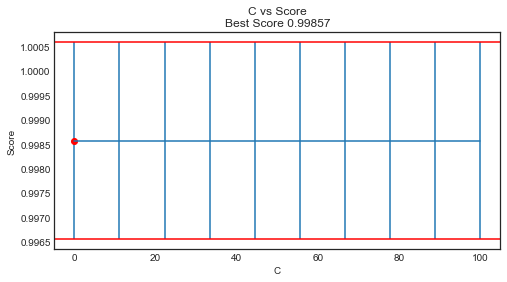

In [269]:
ridgeLrParams = {'C':np.linspace(.003,100,num=10),
              'penalty':('l2',)}
gsRidgeLr = GridSearchCV(LogisticRegression(), ridgeLrParams, return_train_score=True, n_jobs=4)
gsOut = gsRidgeLr.fit(X,y)
GridSearchTablePlot(gsRidgeLr,"C", negative=False)

### Ridge: RidgeClassifier

best parameters: {'alpha': 32.157894736842103}
best score:      0.71429 (+/-0.01693)


,mean_test_score,std_test_score,param_alpha
16,0.714286,0.016935,32.1579
19,0.712857,0.015601,35
4,0.712857,0.007504,20.7895
18,0.712857,0.015601,34.0526
15,0.712857,0.014918,31.2105
17,0.711429,0.012904,33.1053
1,0.710000,0.013615,17.9474
2,0.710000,0.011138,18.8947
3,0.710000,0.011138,19.8421
5,0.710000,0.005898,21.7368


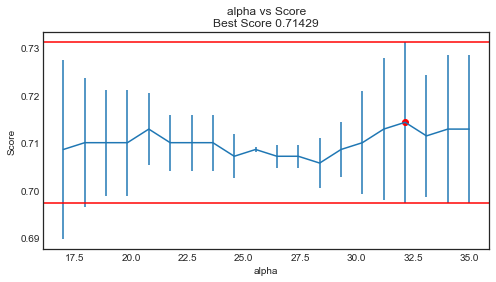

In [270]:
params = {'alpha':np.linspace(17,35,num=20)}
gslrr = GridSearchCV(linear_model.RidgeClassifier(), params, return_train_score=True, n_jobs=4)
gsOut = gslrr.fit(X,y)
GridSearchTablePlot(gslrr,"alpha", negative=False)

### Lasso: LogisticRegression

best parameters: {'C': 0.0057142857142857143, 'penalty': 'l1'}
best score:      0.99571 (+/-0.00350)


,mean_test_score,std_test_score,param_C,param_penalty
4,0.995714,0.003502,0.00571429,l1
7,0.995714,0.003502,0.007,l1
0,0.994286,0.004036,0.004,l1
1,0.994286,0.004036,0.00442857,l1
2,0.994286,0.004036,0.00485714,l1
3,0.994286,0.004036,0.00528571,l1
14,0.994286,0.004036,0.01,l1
5,0.992857,0.005346,0.00614286,l1
8,0.992857,0.007293,0.00742857,l1
9,0.992857,0.007293,0.00785714,l1


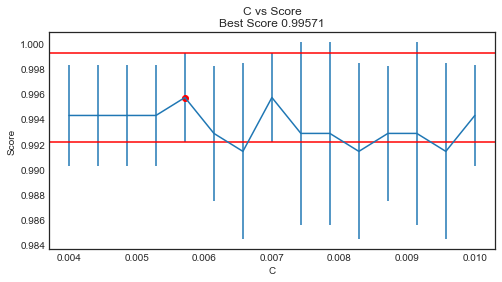

In [271]:
lassoParams = {'C':np.linspace(.004,.01,15),
              'penalty':('l1',)}
gslsr = GridSearchCV(LogisticRegression(), lassoParams, return_train_score=True, n_jobs=4)
gsOut = gslsr.fit(X,y)
GridSearchTablePlot(gslsr,"C", negative=False)

### Ridge, Excluding "goals" feature

In [298]:
autoListOfCs=[.001,.003,.03,.2,.3]
npListOfCs=np.linspace(.001,.015,20,endpoint=False)

best parameters: {'C': 0.0051999999999999989, 'penalty': 'l2'}
best score:      0.82429 (+/-0.01430)


,mean_test_score,std_test_score,param_C,param_penalty
7,0.824286,0.014300,0.0059,l2
6,0.824286,0.014300,0.0052,l2
5,0.822857,0.016074,0.0045,l2
9,0.820000,0.019764,0.0073,l2
12,0.820000,0.019764,0.0094,l2
18,0.820000,0.019764,0.0136,l2
19,0.820000,0.019764,0.0143,l2
4,0.820000,0.012881,0.0038,l2
8,0.818571,0.021657,0.0066,l2
10,0.818571,0.018225,0.008,l2


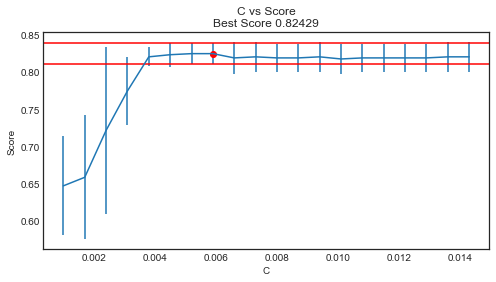

In [299]:
ridgeLrParams = {'C':npListOfCs,
              'penalty':('l2',)}
gsRidgeLr = GridSearchCV(LogisticRegression(), ridgeLrParams, return_train_score=True, n_jobs=4)
gsOut = gsRidgeLr.fit(X[['backers','pledged']],y)
GridSearchTablePlot(gsRidgeLr,"C", negative=False)